# 导入必要的库

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '1'
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

# 加载图片并切割出两张图的对应区域
这里的坐标需要根据自己实际做屏幕坐标测量

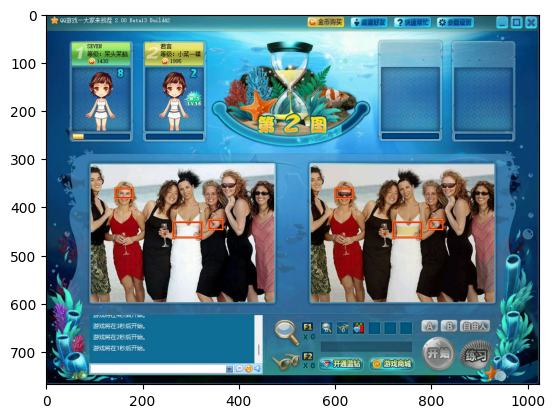

In [2]:
test_img = plt.imread('./test.jpg')
plt.imshow(test_img)

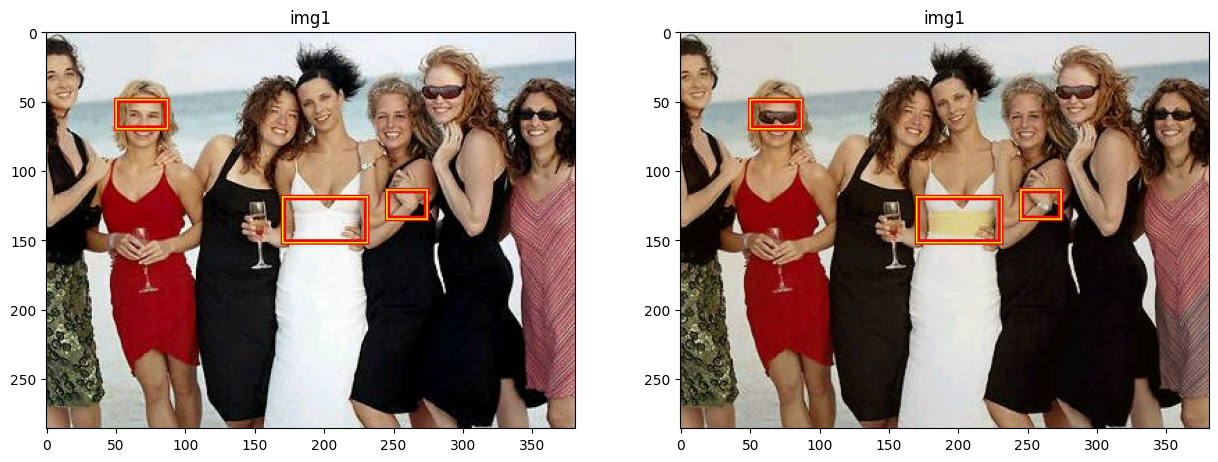

In [3]:
IMG1_TOP = 312
IMG1_BOTTOM = 598
IMG1_LEFT = 93
IMG1_RIGHT = 474
IMG2_OFFSET = IMG1_RIGHT-IMG1_LEFT+76
img1 = test_img[IMG1_TOP:IMG1_BOTTOM,IMG1_LEFT:IMG1_RIGHT,:]
img2 = test_img[IMG1_TOP:IMG1_BOTTOM,IMG1_LEFT+IMG2_OFFSET:IMG1_RIGHT+IMG2_OFFSET,:]


plt.figure(figsize=(15,15))
plt.subplot(121)
plt.title('img1')
plt.imshow(img1)
plt.subplot(122)
plt.title('img1')
plt.imshow(img2)
plt.show()

> 以上的框框是我先前自己手动找出来的不同处，但还剩下两个地方使比较难找到的，一是右3黑色衣服的女士手上的手表，二是右一红色衣服女士的下半身裙子的颜色有细微不同

## 两张图整体明度差异
观察发现两张图的明度不一致，故取两张图在每个分量上的均值取一个差值，并给其中一个图像施加一个偏移量使两张图在明度上大体一致

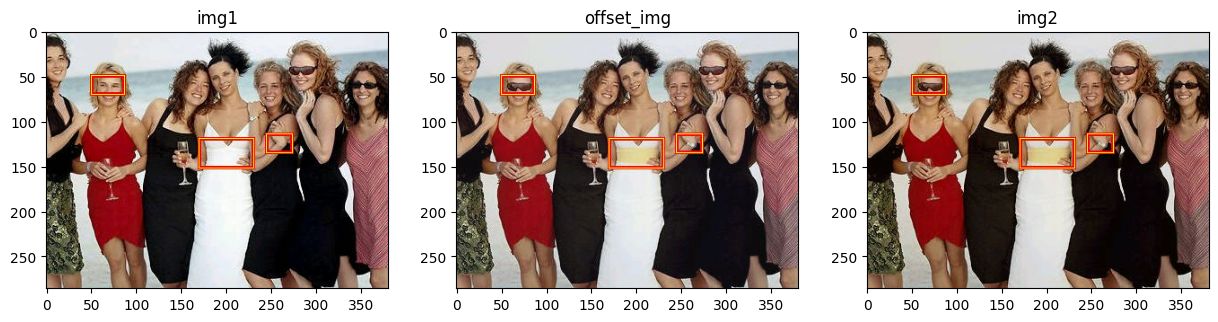

In [4]:
offset = img1.mean(0).mean(0) - img2.mean(0).mean(0)
offset_img = np.zeros(img1.shape)
offset_img[:,:,0] = offset[0]
offset_img[:,:,1] = offset[1]
offset_img[:,:,2] = offset[2]
offset_img = offset_img.astype(np.uint8)
offset_img = cv.add(img2,offset_img)

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.title('img1')
plt.imshow(img1)
plt.subplot(132)
plt.title('offset_img')
plt.imshow(offset_img)
plt.subplot(133)
plt.title('img2')
plt.imshow(img2)
plt.show()

## 提取两图不一样处
使用两张图进行一个差，并取其绝对值。  
不过在此之前需要对图像进行一些处理，首先是对其进行一个滤波，这样操作可以使图像消除大部分噪声以减少大部分干扰。  
最后就是将其进行灰度化并使其二值化

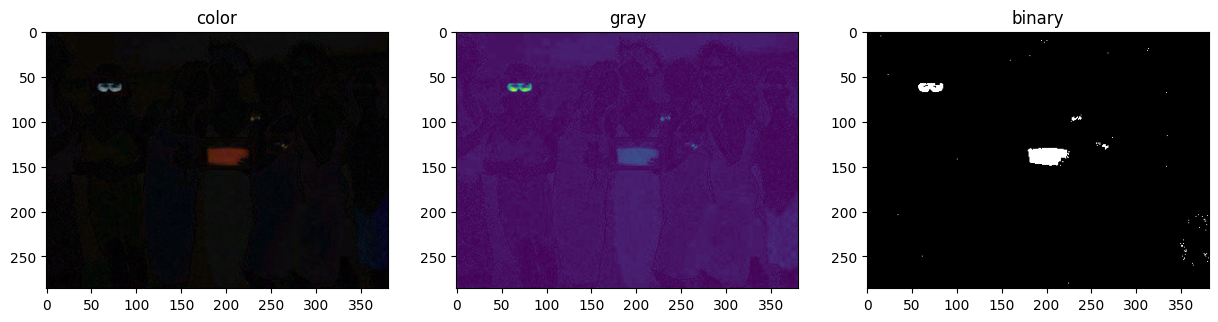

In [5]:
img2 = offset_img
img1_bgr = cv.cvtColor(img1,cv.COLOR_RGB2BGR)
img2_bgr = cv.cvtColor(img2,cv.COLOR_RGB2BGR)
img1_blur = cv.blur(img1_bgr,(2,2)).astype(np.int16)
img2_blur = cv.blur(img2_bgr,(2,2)).astype(np.int16)
newimg = abs(img2_blur-img1_blur).astype(np.uint8)
new_gray_img = cv.cvtColor(newimg,cv.COLOR_BGR2GRAY)
new_gray_img = new_gray_img.astype(np.uint8)
ret,thresh = cv.threshold(new_gray_img,20,1,cv.THRESH_BINARY)#经测试阈值设置为20较为合理


plt.figure(figsize=(15,15))
plt.subplot(131)
plt.title('color')
plt.imshow(newimg)
plt.subplot(132)
plt.title('gray')
plt.imshow(new_gray_img)
plt.subplot(133)
plt.title('binary')
plt.imshow(thresh,cmap='gray')

观察gray图像可以发现右一女士的衣服并没有在进行差值运算的时候并没有很好的显现出来，虽然在rgb图像来看也不是很明显，但可以很清楚地看到右下角的蓝色区块是有明显区别于别的区域的，而在gray图像中右下角的区域和别的噪声区域别无二致，在将gray图像二值化之后也是完全看不到右下角区域的存在————这不是通过调整阈值可以解决的。

推测的原因可能是rgb转换成gray图像的时候损失了一部分色彩信息。[具体看rgb转gray算法原理](https://juejin.cn/s/rgb%E8%BD%AC%E7%81%B0%E5%BA%A6%E5%9B%BE)。下面通过对三个通道单独操作的方式将其进行优化。

1. 提取两张图的三通道并两两绝对值相减
2. 对三张通道的灰度图进行消噪
3. 对每个通道计算一个平方运算，使其突出相减之后的突出像素与周围的像素的差距变大，由于图像的像素范围只有0~255所以可能会有越界的像素，故乘以一个系数进行抑制
4. 将三个通道进行相加，形成一张新的灰度图


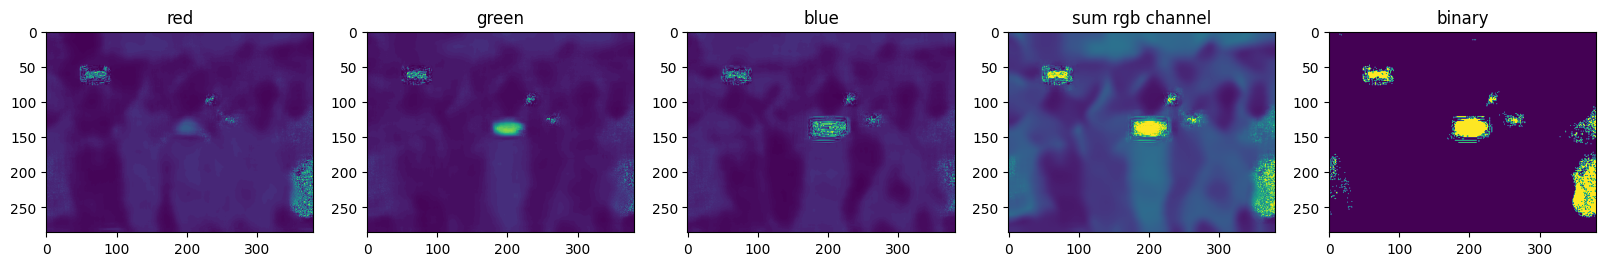

In [6]:
img2 = offset_img
redimg = abs(img1[:,:,0].astype('int16') - img2[:,:,0].astype('int16')).astype('uint8')
greenimg = abs(img1[:,:,1].astype('int16') - img2[:,:,1].astype('int16')).astype('uint8')
blueimg = abs(img1[:,:,2].astype('int16') - img2[:,:,2].astype('int16')).astype('uint8')
redimg = cv.fastNlMeansDenoising(redimg,0.5,7,21)
greenimg = cv.fastNlMeansDenoising(greenimg,0.5,7,21)
blueimg = cv.fastNlMeansDenoising(blueimg,0.5,7,21)

redimg = redimg.astype('int16')
redimg = (redimg*redimg*0.2).astype('uint8')

greenimg = greenimg.astype('int16')
greenimg = (greenimg*greenimg*0.2).astype('uint8')

blueimg = blueimg.astype('int16')
blueimg = (blueimg*blueimg*0.2).astype('uint8')

rgbimg = cv.add(redimg,greenimg)
rgbimg = cv.add(rgbimg,blueimg)

ret,thresh = cv.threshold(rgbimg,100,1,cv.THRESH_BINARY)
rgbimg = cv.fastNlMeansDenoising(rgbimg,None,7,21)

plt.figure(figsize=(20,20))
plt.subplot(151)
plt.title('red')
plt.imshow(redimg)
plt.subplot(152)
plt.title('green')
plt.imshow(greenimg)
plt.subplot(153)
plt.title('blue')
plt.imshow(blueimg)
plt.subplot(154)
plt.title('sum rgb channel')
plt.imshow(rgbimg)
plt.subplot(155)
plt.title('binary')
plt.imshow(thresh)

## 绘制轮廓并画出中心点，使用pyautogui点击中心点

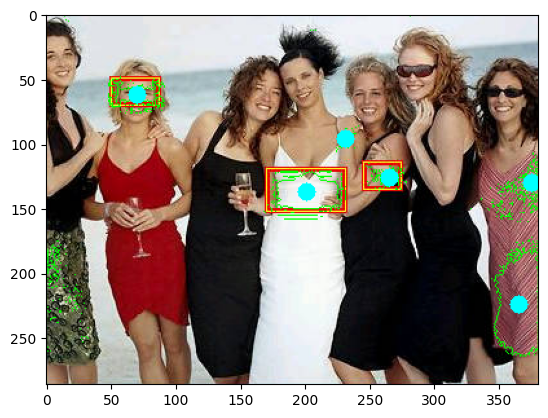

In [7]:
"""
Parameter2------
RETR_EXTERNAL：仅仅检测外圈轮廓
RETR_LIST：检测所有轮廓，但是没有层级关系
RETR_CCOMP：仅仅两层包含关系，即只有外层和内层，假设有夹层，那么夹层也算外层，只要某个轮廓还包含有轮廓，都算外部轮廓
RETR_TREE：检测所有的轮廓，并建议非常完整的层级关系
RETR_FLOODFILL：无描述

Parameter3------
CHAIN_APPROX_NONE：相邻的轮廓点坐标只相差一个像素，所以是连续轮廓点
CHAIN_APPROX_SIMPLE：横、竖、对角线段只保存断点数据，比如矩形就只保存四个顶点。
"""
contours, hierarchy = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours = sorted(list(contours),key = lambda x:cv.contourArea(x),reverse=True)
nimg = cv.drawContours(img1, contours, -1, (0,255,0), 1)
plt.imshow(nimg)
for i in range(6):
    M = cv.moments(contours[i])
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    cv.circle(nimg, (cX, cY), 7, (0, 255, 255), -1)
plt.imshow(nimg)